# 1 : Librairies et Options

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import tqdm
import time

from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from lightgbm.sklearn import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from rembg import remove

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran
pd.set_option('display.max_columns', 50)
pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message="[LightGBM]")

# 2 : Ouverture et analyse du fichier

In [2]:
Champignons = pd.read_csv('ChampignonsDF.csv')
Champignons.head(3)

,Nom,Comestibilite,TailleChapeauMin,TailleChapeauMax,LamePore,TaillePiedMin,TaillePiedMax,Photos,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Aout,Septembre,Octobre,Novembre,Decembre,InfosGenerales
0,AGARIC AUGUSTE,NonComestible,5.0,25.0,LAMES,6.0,20.0,Agaricauguste.jpg,0,0,0,0,0,0,1,1,1,1,0,0,couvert mèches fond crème jaunissant toucher l...
1,AGARIC DES JACHÈRES,Comestible,5.0,15.0,LAMES,5.0,15.0,Agaricdesjachères.jpg,0,0,0,0,0,1,1,1,1,1,1,0,lisse blanc puis jaunissant vieillissant libre...
2,AGARIC JAUNISSANT,NonComestible,2.0,15.0,LAMES,3.0,15.0,Agaricjaunissant.jpg,0,0,0,0,1,1,1,1,1,1,1,0,blanc grisâtre pâle lisse souvent irrégulier s...


In [3]:
# Analyse des données numériques :
Champignons.describe()

,TailleChapeauMin,TailleChapeauMax,TaillePiedMin,TaillePiedMax,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Aout,Septembre,Octobre,Novembre,Decembre
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,3.269863,13.066210,3.150685,9.570776,0.018265,0.022831,0.054795,0.086758,0.155251,0.292237,0.488584,0.698630,0.949772,0.936073,0.721461,0.164384
std,2.165790,8.247682,1.955382,5.914394,0.134214,0.149707,0.228100,0.282125,0.362974,0.455833,0.501015,0.459904,0.218916,0.245183,0.449307,0.371472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,3.000000,10.000000,3.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,4.000000,15.000000,4.500000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,18.000000,65.000000,10.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Infos Générales :
Champignons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nom               219 non-null    object 
 1   Comestibilite     219 non-null    object 
 2   TailleChapeauMin  219 non-null    float64
 3   TailleChapeauMax  219 non-null    float64
 4   LamePore          219 non-null    object 
 5   TaillePiedMin     219 non-null    float64
 6   TaillePiedMax     219 non-null    float64
 7   Photos            219 non-null    object 
 8   Janvier           219 non-null    int64  
 9   Fevrier           219 non-null    int64  
 10  Mars              219 non-null    int64  
 11  Avril             219 non-null    int64  
 12  Mai               219 non-null    int64  
 13  Juin              219 non-null    int64  
 14  Juillet           219 non-null    int64  
 15  Aout              219 non-null    int64  
 16  Septembre         219 non-null    int64  
 1

In [5]:
# Factorization de la colonne Comestibilite qui va me servir de Y :
Champignons['ComestibiliteFAC'] = Champignons['Comestibilite'].factorize()[0]
Champignons[['Comestibilite','ComestibiliteFAC']].value_counts()

Comestibilite  ComestibiliteFAC
NonComestible  0                   116
Comestible     1                   103
Name: count, dtype: int64

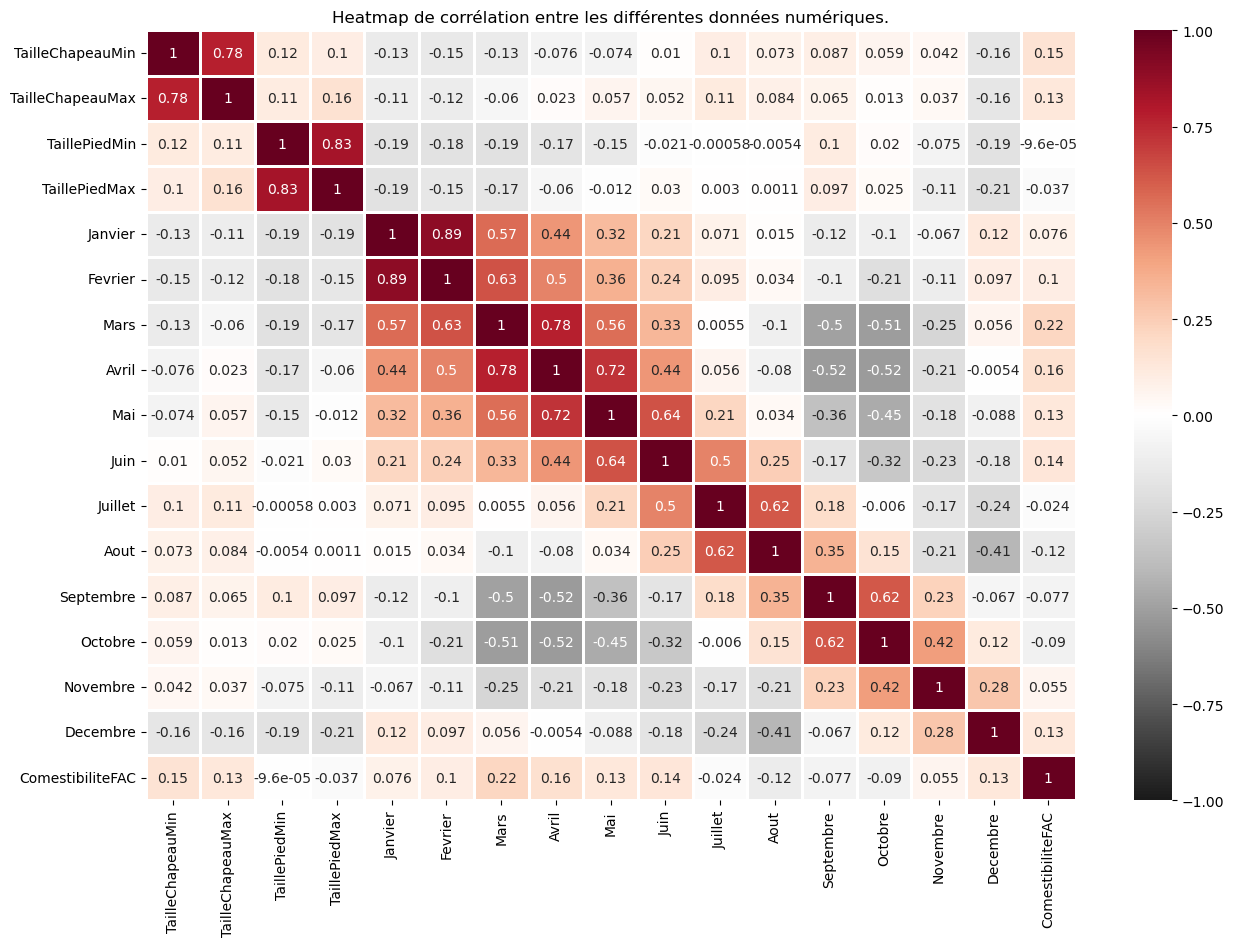

In [6]:
# Heatmap de corrélation :
plt.subplots(figsize = (15,10))
sns.heatmap(Champignons.select_dtypes(include = 'number').corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, cmap = "RdGy_r")
plt.title('Heatmap de corrélation entre les différentes données numériques.')
plt.show()

- **Visuellement la Comestibilité n'est pas corrélé avec le reste.**
- **On observe une corrélation entre les tailles min et max des chapeaux ou des pieds.**
- **Il semble y avoir des pools de champignons ou d'absence de champignons entre Janvier et Juin, entre Juin et Aout et entre Septembre et Novembre.**

# 3 : Définitions

In [7]:
# Split des données avec stratification pour répartir le différentes catégories :
def TrainTest (X, y) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y)
    return X_train, X_test, y_train, y_test

In [8]:
# Réduction des variables par PCA :
def PCA (value, nb):
    pca = decomposition.PCA(n_components = nb)
    feat_pca= pca.fit_transform(value)
    return feat_pca

In [9]:
# Réduction des variables par TSNE (en 2D pour visualisation des clusters) :
def TSNE (value) : 
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(value)
    return X_tsne

In [10]:
# Graphiques avec les vrais labels et les labels issus d'un KMeans :
def graphsTSNE (X_tsne) : 
    # Graphiques vraies classes :
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = Champignons['ComestibiliteFAC']

    plt.subplots(1, 3, figsize=(20,5))
    plt.subplot(131)
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", palette=sns.color_palette('tab10', n_colors=2), s=50, alpha=0.6,
        data = df_tsne, legend="brief")

    plt.title('TSNE selon les vraies classes :', fontsize = 15, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 
    
    # graphiques avec classes faites par KMeans :
    cls = cluster.KMeans(n_clusters=4, n_init=100)
    cls.fit(X_tsne)
    df_tsne["cluster"] = cls.labels_

    plt.subplot(132)
    sns.scatterplot(x="tsne1", y="tsne2", hue="cluster",
    palette = sns.color_palette('tab10', n_colors=2), s=50, alpha=0.6,
    data=df_tsne, legend="brief")

    plt.title('TSNE selon les clusters :', fontsize = 15, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14})

    
    # Création de la matrice de confusion :
    labels = Champignons['ComestibiliteFAC']
    conf_mat = metrics.confusion_matrix(labels, cls.labels_)
    corresp = np.argmax(conf_mat, axis=0)
    labels = pd.Series(labels, name="y_true").to_frame()
    labels['y_pred'] = cls.labels_
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])


    cls_labels_transform = np.array(labels['y_pred_transform'])
    labels = Champignons['ComestibiliteFAC']
    conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
    list_labels = Champignons['Comestibilite'].unique()

    df_cm = pd.DataFrame(conf_mat2, index = [label for label in list_labels], columns=[label for label in list_labels])
    
    plt.subplot(133)
    plt.title('Matrice de confusion :', size = 15, fontweight = 'bold' )
    sns.heatmap(df_cm.T, annot=True, cmap="Blues")
    plt.xlabel('Groupes KMeans', fontsize = 15, fontweight = 'bold')
    plt.show()
    
    print("La mesure de ARI est de {} pour ce modèle d'extraction des features.".format(round(metrics.adjusted_rand_score(labels, cls.labels_),3)))

In [11]:
# Regression Logistic :

def RL (X_train, y_train, X_test, y_test) :
    start = time.time()
    modelLR = LogisticRegression(max_iter = 1000).fit(X_train, y_train)
    end = time.time()
    
    AccuracyTrain = round(modelLR.score(X_train,y_train),3)
    AccuracyTest = round(modelLR.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [12]:
# Arbre de décision :

def DecisionTree (X_train, y_train, X_test, y_test) :
    start = time.time()
    dico = {'max_depth' : range(2,5), "min_samples_leaf" : [5, 10, 15, 20]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelDTC = GridSearchCV(DecisionTreeClassifier(random_state = 42), dico, refit=True, cv = SKF).fit(X_train, y_train)
    end = time.time()

    AccuracyTrain = round(modelDTC.score(X_train,y_train),3)
    AccuracyTest = round(modelDTC.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [13]:
# KNN :

def KNN (X_train, y_train, X_test, y_test) :
    start = time.time()
    dico = {'n_neighbors' : range(2,50), 'weights' : ['uniform', 'distance']}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelKNN = GridSearchCV(KNeighborsClassifier(), dico, refit=True, cv = SKF).fit(X_train, y_train)
    end = time.time()

    AccuracyTrain = round(modelKNN.score(X_train,y_train),3)
    AccuracyTest = round(modelKNN.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [14]:
# Random Forest :

def RandomForest (X_train, y_train, X_test, y_test) :
    start = time.time()
    dico = {'max_depth' : range(3,6), 'n_estimators' : [300,400,500], 'min_samples_leaf': [4, 5, 6]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelRF = GridSearchCV(RandomForestClassifier(random_state = 42), dico, refit=True, cv = SKF).fit(X_train, y_train)
    end = time.time()

    AccuracyTrain = round(modelRF.score(X_train,y_train),3)
    AccuracyTest = round(modelRF.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [15]:
# Suport Vecteur Machine :

def SVM (X_train, y_train, X_test, y_test) :
    start = time.time()
    dico = {'C': np.logspace(-2, 5, 6), 'gamma': np.logspace(-4, 1, 6)}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    modelSVC = GridSearchCV(SVC(), dico, cv = SKF, refit=True).fit(X_train, y_train)
    end = time.time()

    AccuracyTrain = round(modelSVC.score(X_train,y_train),3)
    AccuracyTest = round(modelSVC.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [16]:
# LightGBM :

def lightGBM (X_train, y_train, X_test, y_test) :
    start = time.time()
    # Step 1: Trouver le bon learning rate et le bon n estimator.

    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    dico1 = {'learning_rate': [0.1, 0.01], 'n-estimators': [100, 1000]}
    modelLGB1 = GridSearchCV(LGBMClassifier(random_state = 42, verbose=-1, objective="binary"), dico1, cv = SKF, refit = True, n_jobs = -1).fit(X_train, y_train)
    BestEstimator = modelLGB1.best_params_['n-estimators']
    BestLearningRate = modelLGB1.best_params_['learning_rate']

    # Step 2: Tune max_depth and min_child_weight.

    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    dico2 = {'max_depth': [3, 5, 7], 'min_child_weight': [1, 3]}
    modelLGB2 = GridSearchCV(LGBMClassifier(random_state = 42, learning_rate = BestLearningRate, n_estimators = BestEstimator, verbose = -1, objective="binary"), dico2, cv = SKF, refit = True, n_jobs = -1).fit(X_train, y_train)
    BestDepth = modelLGB2.best_params_['max_depth']
    Bestminchildweight = modelLGB2.best_params_['min_child_weight']

    # Step 3: Tuning regularization parameters.

    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
    dico3 = {'reg_alpha':np.arange(0, 1, 0.2), 'reg_lambda': range(0,10,2)}
    modelLGB3 = GridSearchCV(LGBMClassifier(n_jobs = -1, random_state = 42, verbose = -1, learning_rate = BestLearningRate, n_estimators = BestEstimator, max_depth = BestDepth, min_child_weight = Bestminchildweight, objective="binary"), dico3, cv = SKF, refit = True).fit(X_train, y_train)
    Bestregalpha = modelLGB3.best_params_['reg_alpha']
    Bestreglambda = modelLGB3.best_params_['reg_lambda']
    
    end = time.time()

    AccuracyTrain = round(modelLGB3.score(X_train,y_train),3)
    AccuracyTest = round(modelLGB3.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [17]:
def lightGBM2 (X_train, y_train, X_test, y_test) :
    start = time.time()

    dico = { 'learning_rate':        Real(0.01, 0.1),
             'n-estimators' :        Integer(10,1000),
             'num_leaves':           Integer(20, 100),
             'reg_alpha':            Real(0, 1),
             'reg_lambda':           Real(0, 10),
             'max_depth':            Integer(3, 10),
             'min_child_weight' :    Integer(1, 3)}

    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)

    model = BayesSearchCV(LGBMClassifier(seed = 1, verbose = -1), dico, cv = SKF, scoring = 'accuracy', n_iter = 100, random_state = 42).fit(X_train, y_train)
    end = time.time()

    AccuracyTrain = round(model.score(X_train,y_train),3)
    AccuracyTest = round(model.score(X_test,y_test),3)
    Duree = end - start
    
    return AccuracyTrain, AccuracyTest, Duree

In [18]:
# Définition récap résultats ML :
def GlobaleML(X_train, y_train, X_test, y_test) :
    Regression = RL(X_train, y_train, X_test, y_test)
    DT = DecisionTree(X_train, y_train, X_test, y_test)
    KNNs = KNN(X_train, y_train, X_test, y_test)
    RF = RandomForest(X_train, y_train, X_test, y_test)
    SVMC = SVM(X_train, y_train, X_test, y_test)
    lightGBMGrid = lightGBM(X_train, y_train, X_test, y_test) 
    lightGBMBayes = lightGBM2(X_train, y_train, X_test, y_test) 

    # Tableau de résultats
    Resultats = pd.DataFrame()
    Models = ['Regression', 'DT', 'KNNs', 'RF', 'SVMC', 'lightGBMGrid', 'lightGBMBayes']
    for model in Models :
        Res = pd.DataFrame(locals()[model]).T.rename(columns = {0:'AccuracyTrain', 1:'AccuracyTest', 2:'DureeModel'}).rename(index = {0 : str(model)})
        Resultats = pd.concat([Resultats, Res])

    # Création d'un score pour hierarchiser les modèles :
    Resultats['Overfitting'] = round(Resultats['AccuracyTrain']/Resultats['AccuracyTest'],2)
    Resultats['BestResult'] = round(Resultats['AccuracyTrain']/Resultats['Overfitting'],2)
    Resultats['DureeModel'] = Resultats['DureeModel'].astype(int)
    Resultats = Resultats.sort_values('BestResult', ascending = False)

    return Resultats

In [19]:
# Définition d'extraction des données des images avec VGG16 :

def VGG16extract(images) :
    base_model = VGG16()
    path = 'PhotosChampignons/'
    model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

    images_features = []
    for image_file in tqdm.tqdm(images):
        image = load_img(path + image_file, target_size=(224, 224))
        image = img_to_array(image) 
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        images_features.append(model.predict(image, verbose=0)[0])

    return np.asarray(images_features)

# 4 : Machine Learning non supervisé :

## 4.1 : Sur les données numériques

In [20]:
# Colonnes de la DF : 
Champignons.select_dtypes(include = 'number').columns

Index(['TailleChapeauMin', 'TailleChapeauMax', 'TaillePiedMin',
       'TaillePiedMax', 'Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin',
       'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre',
       'ComestibiliteFAC'],
      dtype='object')

In [21]:
# Variables :
X = Champignons[['TailleChapeauMin', 'TailleChapeauMax', 'TaillePiedMin', 'TaillePiedMax', 'Janvier', 'Fevrier',
                 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre']]
y = Champignons['ComestibiliteFAC']

In [22]:
# Réduction des dimensions par T-SNE (pour n'avoir que deux dimensions et faire un graphique)
X_tsne = TSNE(X)

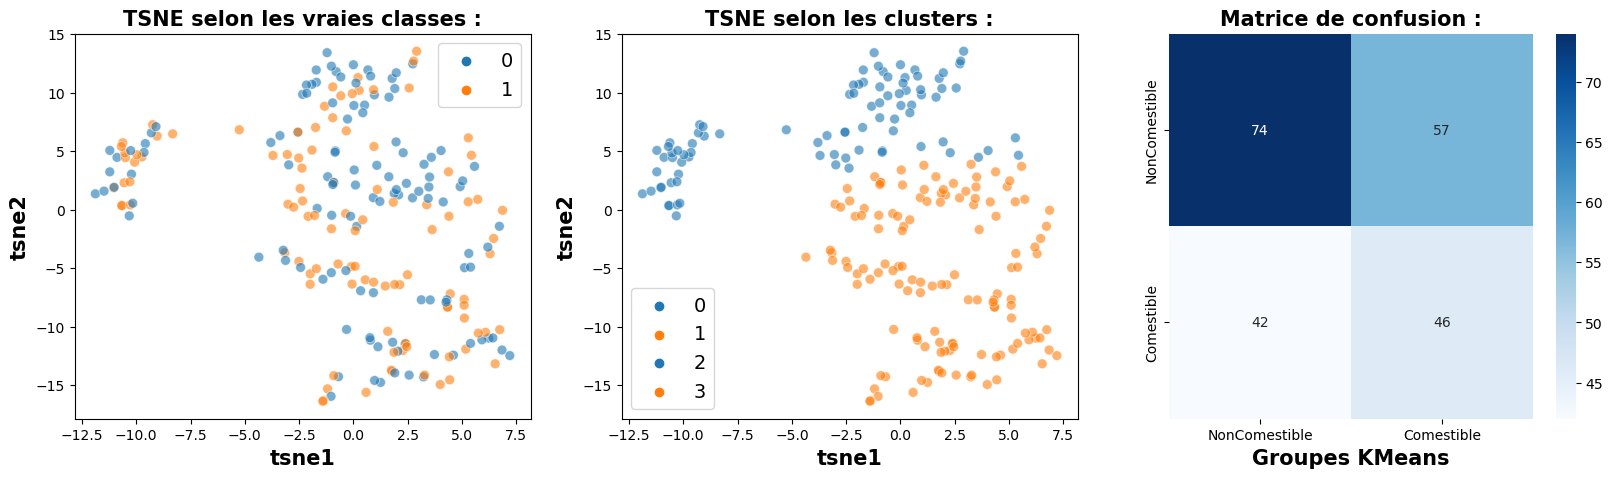

La mesure de ARI est de -0.001 pour ce modèle d'extraction des features.


In [23]:
# Analyse graphique des données :
graphsTSNE(X_tsne)

- **L'analyse des clusters du KMEANS vs classes réelles montrent une trés grosse différences visibles sur la Matrice de Confusion et sur l'ARI.**

- **Definition ARI :** L'Indice de Rand, est la proportion des paires d'éléments qui sont conjointement groupées ou conjointement séparées en considérant de la stochasticité et donc une probabilité d'erreur. Adjusted Rand Index (ARI) est la normalisation de RI qui permet de comparer deux partitions de nombres de classes différentes.

- **Les champignons toxique et mortels ne sont pas mis dans la bonne catégorie, sans doute due au fait qu'on en ait trop peu dans chaque catégorie (ancienne DF).**
- **On observe toujours une classification mauvaise de certains champignons ave un KMEANS.**

##  4.2 : Sur les données textuelles

In [24]:
# Colonnes de la DF : 
Champignons.select_dtypes(exclude = 'number').columns

Index(['Nom', 'Comestibilite', 'LamePore', 'Photos', 'InfosGenerales'], dtype='object')

- **Definition du TF-IDF :** Le TF-IDF est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes. Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus.

In [25]:
# Numérisation des données textuelles via TF-IDF :
tfidf = TfidfVectorizer().fit(Champignons['InfosGenerales'])
matrix_tfidf = tfidf.transform(Champignons['InfosGenerales'])
matrix_tfidf

<219x795 sparse matrix of type '<class 'numpy.float64'>'
	with 6165 stored elements in Compressed Sparse Row format>

In [26]:
# Réduction des dimensions par T-SNE (pour n'avoir que deux dimensions et faire un graphique)
X_tsne = TSNE(matrix_tfidf)

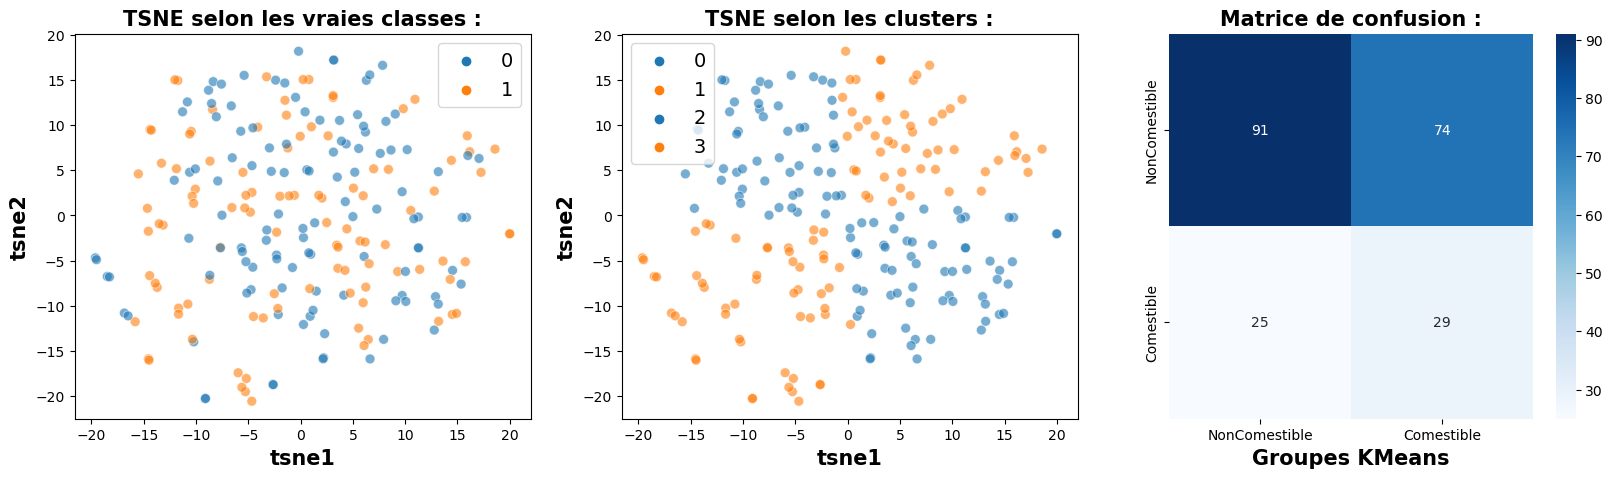

La mesure de ARI est de -0.003 pour ce modèle d'extraction des features.


In [27]:
# Analyse graphique des données :
graphsTSNE(X_tsne)

- **Le KMeans ne peut pas faire des classes vraiment spécifique comestible, non comestible.**

# 4.3 : Sur les données images

In [28]:
# Colonnes de la DF : 
Champignons.select_dtypes(exclude = 'number').columns

Index(['Nom', 'Comestibilite', 'LamePore', 'Photos', 'InfosGenerales'], dtype='object')

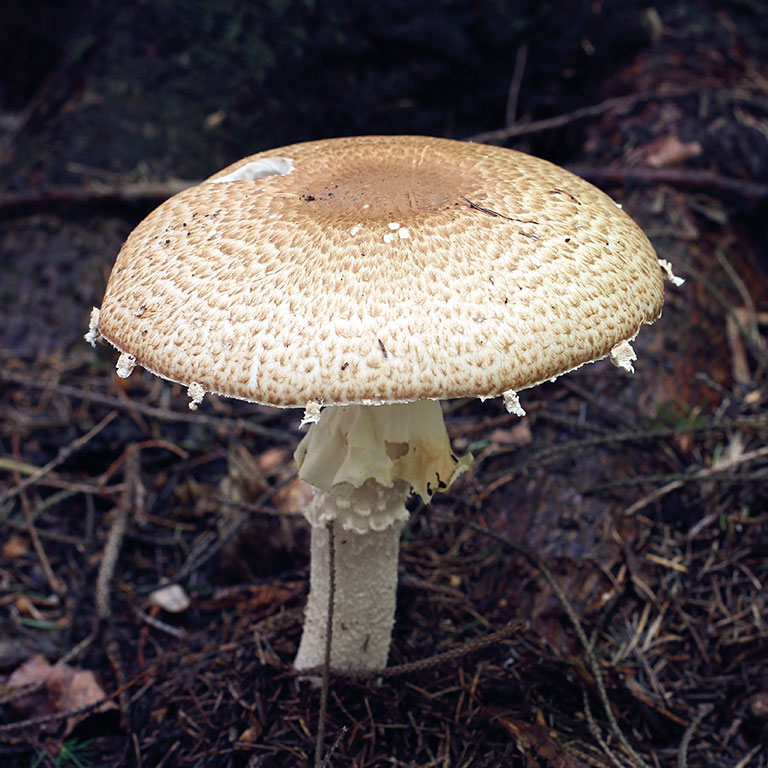

In [29]:
# Ouverture d'une image :
img = Image.open("PhotosChampignons/" + 'Agaricauguste.jpg')
img

In [30]:
# Extraction des données des images avec la définition de VGG16 :
images_features = VGG16extract(Champignons['Photos'])

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:26<00:00,  2.52it/s]


In [31]:
# Réduction des dimmensions :
X_PCA = PCA(images_features, 0.99)
X_tsne = TSNE(X_PCA)

# Réduction des dimensions par T-SNE (pour n'avoir que deux dimensions et faire un graphique)
X_tsne = TSNE(X_tsne)

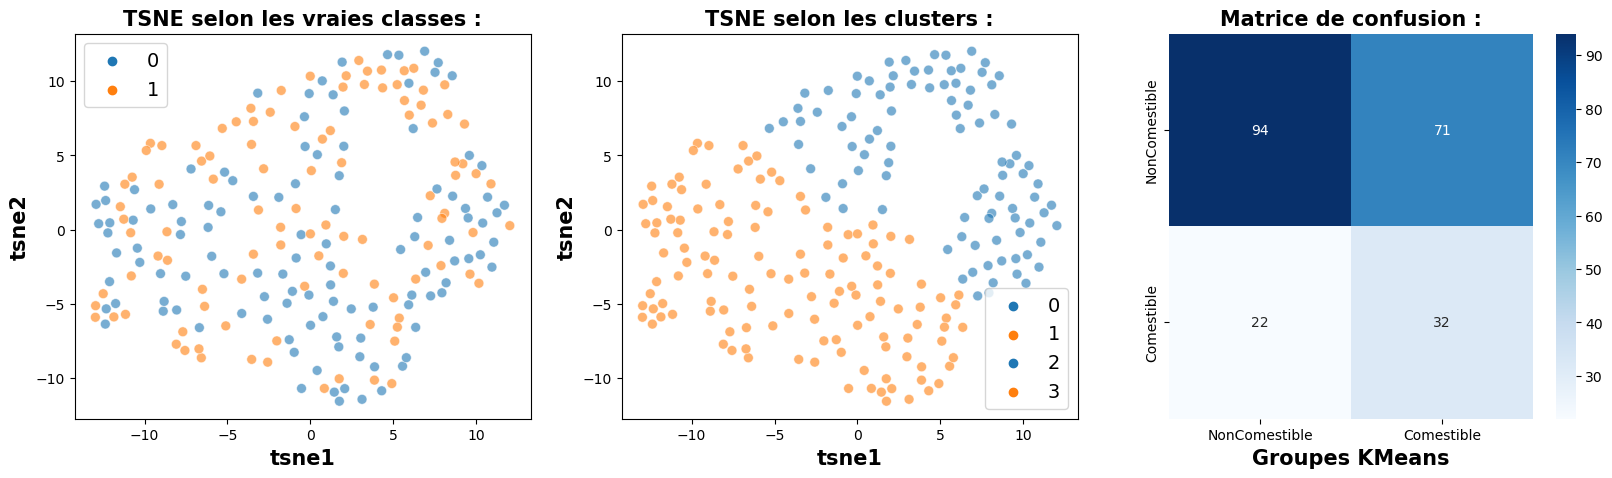

La mesure de ARI est de 0.006 pour ce modèle d'extraction des features.


In [32]:
# Analyse graphique des données :
graphsTSNE(X_tsne)

- **Toujours les mêmes types de résultats.**

# 5 : Machine Learning de Classification Supervisé 

## 5.1 : Sur les données numériques

In [33]:
# Variables :
X = Champignons[['TailleChapeauMin', 'TailleChapeauMax', 'TaillePiedMin', 'TaillePiedMax', 'Janvier', 'Fevrier',
                 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Decembre']]
y = Champignons['ComestibiliteFAC']
X.shape

(219, 16)

In [34]:
# Réduction des dimmensions :
X_PCA = PCA(X, 0.99)
X_PCA.shape

(219, 5)

In [35]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
lightGBMGrid,0.817,0.636,7,1.28,0.64
SVMC,0.680,0.591,1,1.15,0.59
RF,0.797,0.576,49,1.38,0.58
lightGBMBayes,0.712,0.561,324,1.27,0.56
KNNs,0.627,0.530,1,1.18,0.53
Regression,0.595,0.485,0,1.23,0.48
DT,0.660,0.470,0,1.40,0.47


- **Ces résultats montrent que les modèles sont insuffisants ou en overfitting pour déterminer si oui ou non un champignon est considéré comme mauvais en utilisant juste les données numériques.**

##  5.2 : Sur les données textuelles

In [36]:
# Variables :
X = matrix_tfidf
y = Champignons['ComestibiliteFAC']

In [37]:
# Réduction des dimmensions (le PCA ne marchant pas sur des matrix):
svd = TruncatedSVD(n_components = 500, random_state=42)
X = svd.fit_transform(matrix_tfidf)

In [38]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
lightGBMGrid,0.817,0.636,8,1.28,0.64
SVMC,0.680,0.591,1,1.15,0.59
RF,0.797,0.576,63,1.38,0.58
lightGBMBayes,0.712,0.561,352,1.27,0.56
KNNs,0.627,0.530,2,1.18,0.53
Regression,0.595,0.485,0,1.23,0.48
DT,0.660,0.470,0,1.40,0.47


- **Ces résultats montrent que les modèles sont insuffisants ou en overfitting pour déterminer si oui ou non un champignon est considéré comme mauvais en utilisant juste les données textuelles.**

# 5.3 : Sur les données images

### 5.3.1 : Sur les données initiales

In [39]:
# Variables :
X = images_features
y = Champignons['ComestibiliteFAC']

In [40]:
# Réduction des dimmensions :
X_PCA = PCA(X, 0.99)

In [41]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
SVMC,1.000,0.652,0,1.53,0.65
KNNs,1.000,0.606,75,1.65,0.61
Regression,1.000,0.591,0,1.69,0.59
RF,1.000,0.561,77,1.78,0.56
lightGBMGrid,0.941,0.530,11,1.78,0.53
lightGBMBayes,0.941,0.500,301,1.88,0.50
DT,0.758,0.455,0,1.67,0.45


- **Ces résultats montrent que les modèles sont insuffisants ou en overfitting pour déterminer si oui ou non un champignon est considéré comme mauvais en utilisant juste les données images.**

### 5.3.2 : Sur les données augmentées

**Def :** La data augmentation (augmentation de données) est une technique utilisée en apprentissage automatique, en particulier dans le domaine de la vision par ordinateur, pour augmenter la diversité des données d'entraînement. Elle implique la création de nouvelles instances de données en appliquant des transformations diverses et aléatoires aux données existantes. Ces transformations peuvent inclure des rotations, des retournements, des zooms, des translations, des changements de luminosité, et d'autres modifications. L'objectif de la data augmentation est d'améliorer la robustesse et la généralisation d'un modèle en exposant celui-ci à une plus grande variété de situations pendant l'entraînement, ce qui peut conduire à une meilleure performance sur des données nouvelles et variées lors de la phase de test.

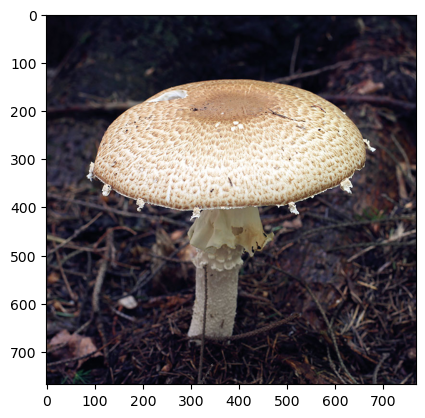

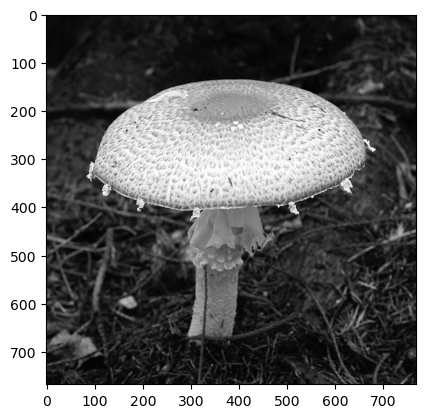

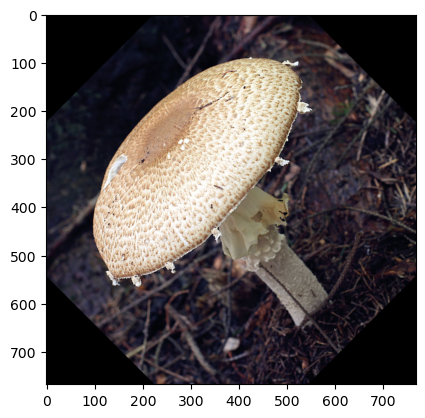

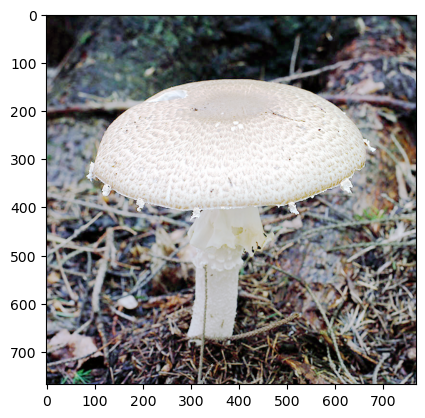

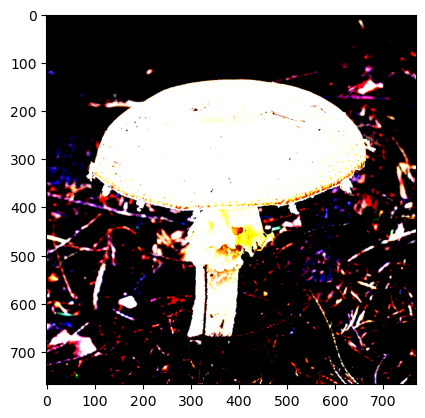

In [42]:
# Ouverture d'une image :
img = Image.open("PhotosChampignons/" + 'Agaricauguste.jpg')
plt.imshow(img)
plt.show()

# Passage en noir et blanc :
filter = ImageEnhance.Color(img)
img2 = filter.enhance(0)
plt.imshow(img2)
plt.show()

# Retournement de la photo :
img3 = img.rotate(45)
plt.imshow(img3)
plt.show()

# Equalization :
img4 = ImageOps.equalize(img, mask = None)
plt.imshow(img4)
plt.show()

# Contrast :
enhancer = ImageEnhance.Contrast(img)
img5 = enhancer.enhance(10)
plt.imshow(img5)
plt.show()

In [43]:
# Extraction des données des images NB avec VGG16 :
base_model = VGG16()
path = 'PhotosChampignons/'
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

images_featuresNB = []

for image_file in tqdm.tqdm(Champignons['Photos']):
    image = load_img(path + image_file, target_size=(224, 224))
    
    # Passage en noir et blanc :
    filter = ImageEnhance.Color(image)
    image = filter.enhance(0)
    
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_featuresNB.append(model.predict(image, verbose=0)[0])
    
images_featuresNB = np.asarray(images_featuresNB)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:28<00:00,  2.48it/s]


In [44]:
# Extraction des données des images Rotation avec VGG16 :
base_model = VGG16()
path = 'PhotosChampignons/'
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

images_featuresRT = []

for image_file in tqdm.tqdm(Champignons['Photos']):
    image = load_img(path + image_file, target_size=(224, 224))
    
    # Rotation de l'image :
    image = image.rotate(45)
    
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_featuresRT.append(model.predict(image, verbose=0)[0])
    
images_featuresRT = np.asarray(images_featuresRT)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:34<00:00,  2.33it/s]


In [45]:
# Extraction des données des images avec contrast avec VGG16 :
base_model = VGG16()
path = 'PhotosChampignons/'
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

images_featuresC = []

for image_file in tqdm.tqdm(Champignons['Photos']):
    image = load_img(path + image_file, target_size=(224, 224))
    
    # Rotation de l'image :
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(10)
    
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_featuresC.append(model.predict(image, verbose=0)[0])
    
images_featuresC = np.asarray(images_featuresC)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:44<00:00,  2.10it/s]


In [46]:
# Merge des données issues des images :
DonneesImages = pd.merge(pd.DataFrame(images_features),pd.DataFrame(images_featuresNB), left_index = True, right_index = True )
DonneesImages.columns = range(DonneesImages.columns.size)
DonneesImages = pd.merge(DonneesImages,pd.DataFrame(images_featuresRT), left_index = True, right_index = True )
DonneesImages.columns = range(DonneesImages.columns.size)
DonneesImages = pd.merge(DonneesImages,pd.DataFrame(images_featuresC), left_index = True, right_index = True )
DonneesImages.columns = range(DonneesImages.columns.size)

In [47]:
# Variables :
X = DonneesImages
y = Champignons['ComestibiliteFAC']

X.shape

(219, 16384)

In [48]:
# Réduction des dimmensions :
X_PCA = PCA(X, 0.99)

X_PCA.shape

(219, 206)

In [49]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
SVMC,1.000,0.682,0,1.47,0.68
RF,1.000,0.621,86,1.61,0.62
DT,0.765,0.591,0,1.29,0.59
Regression,1.000,0.576,0,1.74,0.57
KNNs,1.000,0.545,84,1.83,0.55
lightGBMGrid,0.922,0.545,12,1.69,0.55
lightGBMBayes,0.980,0.485,352,2.02,0.49


- **Même avec l'ajout de 3 data augmentation je n'obtiens pas quelque chose de vraiment bon et fiable.**

### 5.3.3 : Sur les images détourées

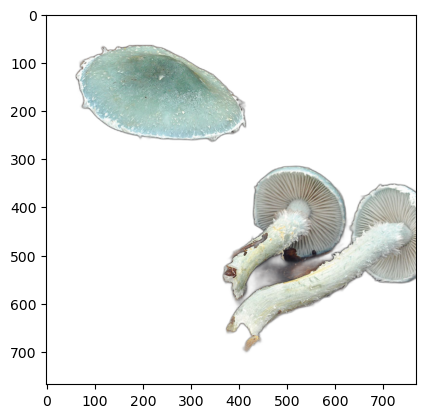

In [50]:
# Détourer une image :
input_path = "PhotosChampignons/" + 'Strophairebleue.jpg'

input = Image.open(input_path)
image = remove(input)
plt.imshow(image)
plt.show()

RGB
RGBA
(224, 224, 4)
RGB


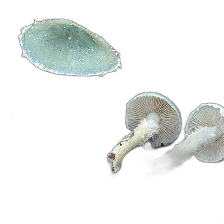

In [51]:
# Etude du mode de l'image (passe de 3 à 2 niveau)
image = load_img("PhotosChampignons/" + 'Strophairebleue.jpg', target_size=(224, 224))
print(image.mode)

image = remove(image)

# Afficher le mode de l'image
print(image.mode) # A pour Alpha

image2 = img_to_array(image)
print(image2.shape)

# Utilisation de ChatGPT pour transformer les pixels transparent en blanc avant de revenir en RGB sinon on obtient un fond noir :
def Niveau3 (image) :
    # Convertir le tableau NumPy en objet Image
    image = Image.fromarray(np.uint8(image))

    # Créer une nouvelle image blanche de la même taille
    background = Image.new("RGB", image.size, (255, 255, 255))

    # Coller l'image sur le fond blanc
    background.paste(image, mask=image.split()[3])  # Utilise le canal alpha comme masque

    # Utiliser l'image résultante
    image = background
    
    return image
    
image = Niveau3 (image)

print(image.mode)
image

In [52]:
# Extraction des données des images détourées avec VGG16 :
base_model = VGG16()
path = 'PhotosChampignons/'
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

images_featuresDT = []

for image_file in tqdm.tqdm(Champignons['Photos']):
    image = load_img(path + image_file, target_size=(224, 224))
    
    # Detourage de l'image :
    image = remove(image)
    
    # revenir au RGB avec un fond blanc :
    image = Niveau3 (image)
    
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_featuresDT.append(model.predict(image, verbose=0)[0])
    
images_featuresDT = np.asarray(images_featuresDT)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [10:11<00:00,  2.79s/it]


In [53]:
# Variables :
X = images_featuresDT
y = Champignons['ComestibiliteFAC']

X.shape

(219, 4096)

In [54]:
# Réduction des dimmensions :
X_PCA = PCA(X, 0.99)

X_PCA.shape

(219, 197)

In [55]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
lightGBMBayes,0.993,0.682,312,1.46,0.68
RF,1.000,0.621,93,1.61,0.62
lightGBMGrid,0.974,0.606,12,1.61,0.60
DT,0.654,0.561,0,1.17,0.56
Regression,1.000,0.515,0,1.94,0.52
SVMC,1.000,0.500,0,2.00,0.50
KNNs,0.569,0.470,75,1.21,0.47


### 5.3.4 : Pour le fun 

In [56]:
# Variables :
X = pd.DataFrame(images_featuresDT)
y = Champignons['ComestibiliteFAC']

X.shape

(219, 4096)

In [57]:
# Doublons les données :
X = pd.concat([X,X])
y = pd.concat([y,y])

X.shape

(438, 4096)

In [58]:
# Réduction des dimmensions :
X_PCA = PCA(X, 0.99)

X_PCA.shape

(438, 197)

In [59]:
# Création des Train / Test :
X_train, X_test, y_train, y_test = TrainTest (X_PCA, y)

# Machine Learning :
GlobaleML(X_train, y_train, X_test, y_test) 

,AccuracyTrain,AccuracyTest,DureeModel,Overfitting,BestResult
SVMC,0.997,0.856,1,1.16,0.86
lightGBMGrid,1.000,0.848,16,1.18,0.85
KNNs,1.000,0.833,75,1.20,0.83
RF,1.000,0.833,117,1.20,0.83
lightGBMBayes,1.000,0.818,309,1.22,0.82
Regression,1.000,0.803,0,1.25,0.80
DT,0.843,0.735,1,1.15,0.73


- **En doublant la quantité de données on a des résultats bien meilleurs mais c'est normal car on colle un peu plus aux données.**